<h1>Research Question</h1>

<b>What factors are most useful for predicting arrests in the City of Chicago?</b>

Prior research indicates that the racial/ethnic makeup of the perpetrator plays a significant role in dictating whether or not the individual is arrested for a given crime committed (https://www.vera.org/downloads/publications/for-the-record-unjust-burden-racial-disparities.pdf). However, this dataset does not contain any physical attributes to describe the perpetrator, so we are unable to look into this claim as it pertains to the City of Chicago.

According to the National Institute of Justice, areas with higher crime tend to be densely populated, which implies that cities—dense, urban areas—are more likely to have high crime rates than suburban or rural areas (https://nij.ojp.gov/topics/articles/preventing-neighborhood-crime-geography-matters). Thus, we can expect that crime rates are significantly higher closer to the city and decrease as one moves outwards toward the suburbs.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import joblib
import json
from graphviz import Source
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt
from math import radians, cos, sin, asin, sqrt, isnan
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("Chicago Crime Dataset.csv")
df = df.sample(frac=0.05, random_state=314)

<h3>Data Acquisition</h3>

The dataset contains a few different metrics for locations, but we can also benefit from calculating the physical distance from the center of the city. This must be calculated using the latitude and longitude values given. The generally-accepted center of the city is (41.8781, -87.6298). We can use the following distance function for latitudes and longitudes and apply it to each row of the dataset using a lambda function:

In [3]:
def distance(lat1, lat2, long1, long2):
    # Credit: https://www.geeksforgeeks.org/program-distance-two-points-earth/
    a = sin((radians(lat2) - radians(lat1)) / 2) ** 2 + cos(radians(lat1)) \
        * cos(radians(lat2)) * sin((radians(long2) - radians(long1)) / 2) ** 2
    return asin(sqrt(a)) * 3956 * 2

In [4]:
city_lat = 41.8781
city_long = -87.6298
col = "Distance to City Center"
df[col] = df.apply(lambda x: distance(x["Latitude"], city_lat, \
                x["Longitude"], city_long) if not (isnan(x["Latitude"] and isnan(x["Longitude"]))) else None, axis=1)

Now we can group crime reports by their distance from the center of the city.

In [5]:
distance = df.groupby([col]).count().reset_index()
print(df[col].min(), df[col].median(), df[col].max())

0.003680584700384025 6.687870493809312 422.8168989541127


<h3>Data Cleaning</h3>

We can see a few basic statistics of the data above. There exists a very clear and present outlier in the data, which oddly appears more than once in the dataset. One of the locations is tagged as being approximately 400 miles away from the center of the city; even though wards and blocks are given for these rows, we cannot be entirely sure of the distance. So, we need to remove any rows that are tagged with this location.

In [6]:
df = df.drop(df.index[df[col] > 50])
distance = distance.drop(distance.index[distance[col] > 50])
df = df[df[col].notna()]

In [85]:
bins = [i * 2 for i in range(10)]
groups = df.groupby(pd.cut(df['Distance to City Center'], bins=bins)).size()
groups

Distance to City Center
(0, 2]      31948
(2, 4]      44025
(4, 6]      82402
(6, 8]      95156
(8, 10]     71481
(10, 12]    28256
(12, 14]    18571
(14, 16]     6071
(16, 18]      437
dtype: int64

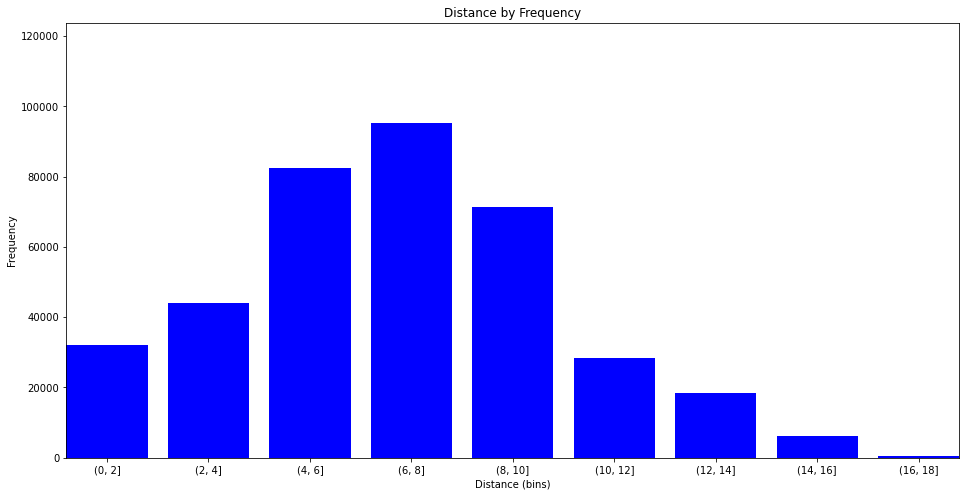

In [88]:
plt.subplots(figsize=(16, 8))


plt.bar(["(" + str(bins[i]) + ", " + str(bins[i + 1]) + "]" for i in range(len(bins) - 1)], groups, color="blue")

plt.title("Distance by Frequency")
plt.xlabel("Distance (bins)")
plt.ylabel("Frequency")
plt.margins(0, 0.3)
plt.show()

In [7]:
drop_columns = ['ID', 'Case Number', 'Block', 'IUCR', 'Description', 'Beat', 'Ward', 'Community Area', 'FBI Code', \
                'X Coordinate', 'Y Coordinate', 'Updated On', 'Latitude', 'Longitude', 'Location', 'Year', 'District']

df = df.drop(drop_columns, axis=1)

We also need to clean the data columns that we will be using that already exist. Some instances of invalid police districts occur, so we need to get rid of those.

In [8]:
# df = df[df['District'].notna()]

Remove any rows with invalid years. Per the dataset description, the crimes are 2001 - Present, so we should keep columns with numeric values greater than 2000.

In [9]:
# df = df[df['Year'].notna()]
# df = df.drop(df.index[df['Year'] < 2001])

In [10]:
def datetime_to_mins(date):
    time = date[-11:]
    newtime = 0

    if time[-2:] == 'PM' and time[:2] != '12':
        newtime += (int(time[:2]) + 12) * 60
    else:
        newtime += int(time[:2]) * 60

    newtime += int(time[3:5])
    
    return newtime

In [11]:
for i, row in df.iterrows():
    df.at[i, 'Date'] = datetime_to_mins(df.at[i, 'Date'])

df.rename(columns={'Date' : 'Time of Day'}, inplace=True)
df.head()

,Time of Day,Primary Type,Location Description,Arrest,Domestic,Distance to City Center
560001,320,BATTERY,PARKING LOT/GARAGE(NON.RESID.),False,False,11.057529
7048133,1245,THEFT,STREET,True,False,4.199559
131692,300,THEFT,SIDEWALK,False,False,4.203769
5271491,640,BATTERY,APARTMENT,False,True,8.096862
4711838,765,OTHER OFFENSE,STREET,True,False,5.821145


Finally, we need to get rid of any rows that don't have a location description listed, as we will use this field to help train our model.

In [12]:
df = df[df['Location Description'].notna()]

<h3>Feature Engineering</h3>

Since most of our data is categorical, we first need a way to encode it. Take the IUCR codes, for example. While represented by numbers, this is not numeric data; it is not ordered such that codes with higher numeric values are more violent crimes. The codes themselves are categorical, which is apparent when considering the fact that the primary types can span several codes.

The most intuitive encoding we can use is one-hot, in which we create new columns in the dataset to represent the span of the categorical attribute. These essentially make up a binary vector, in which the categorical value for any given row holds a 1 in that corresponding column, and 0s in the rest.

First, the encoding for the Primary Type:

In [13]:
def one_hot(df, fields, category):
    cols = []
    
    for field in fields:
        temp = []

        for value in df[category]:
            if value == field:
                temp.append(1)
            else:
                temp.append(0)

        # df[field] = temp
        cols.append(temp)
    
    data_dict = {}
    
    for i, key in enumerate(fields):
        data_dict[key] = cols[i]
    
    return pd.concat((df.reset_index(drop=True), pd.DataFrame(data=data_dict).reset_index(drop=True)), axis=1)

In [14]:
types = {}

for value in df['Primary Type']:
    #if value not in types:
     types[value] = 1
        
print(types, len(types))

{'BATTERY': 1, 'THEFT': 1, 'OTHER OFFENSE': 1, 'NARCOTICS': 1, 'BURGLARY': 1, 'SEX OFFENSE': 1, 'CRIMINAL TRESPASS': 1, 'CRIM SEXUAL ASSAULT': 1, 'WEAPONS VIOLATION': 1, 'ROBBERY': 1, 'DECEPTIVE PRACTICE': 1, 'ASSAULT': 1, 'CRIMINAL DAMAGE': 1, 'OFFENSE INVOLVING CHILDREN': 1, 'MOTOR VEHICLE THEFT': 1, 'PUBLIC PEACE VIOLATION': 1, 'CONCEALED CARRY LICENSE VIOLATION': 1, 'PROSTITUTION': 1, 'HOMICIDE': 1, 'GAMBLING': 1, 'KIDNAPPING': 1, 'LIQUOR LAW VIOLATION': 1, 'INTERFERENCE WITH PUBLIC OFFICER': 1, 'STALKING': 1, 'INTIMIDATION': 1, 'ARSON': 1, 'CRIMINAL SEXUAL ASSAULT': 1, 'NON-CRIMINAL': 1, 'OTHER NARCOTIC VIOLATION': 1, 'OBSCENITY': 1, 'RITUALISM': 1, 'NON - CRIMINAL': 1, 'PUBLIC INDECENCY': 1, 'HUMAN TRAFFICKING': 1} 34


In [15]:
df = one_hot(df, types, 'Primary Type')

We can check that the Primary Type (IUCR Description) has been encoded:

In [16]:
for i in range(5):
    if df.at[i, df.at[i, 'Primary Type']] != 1:
        print("Encoding unsuccessful")
df.head()

,Time of Day,Primary Type,Location Description,Arrest,Domestic,Distance to City Center,BATTERY,THEFT,OTHER OFFENSE,NARCOTICS,...,INTIMIDATION,ARSON,CRIMINAL SEXUAL ASSAULT,NON-CRIMINAL,OTHER NARCOTIC VIOLATION,OBSCENITY,RITUALISM,NON - CRIMINAL,PUBLIC INDECENCY,HUMAN TRAFFICKING
0,320,BATTERY,PARKING LOT/GARAGE(NON.RESID.),False,False,11.057529,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1245,THEFT,STREET,True,False,4.199559,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,300,THEFT,SIDEWALK,False,False,4.203769,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,640,BATTERY,APARTMENT,False,True,8.096862,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,765,OTHER OFFENSE,STREET,True,False,5.821145,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Now we need to encode the Police District field. We can use the same technique from before to retrieve all of the districts that appear in the dataset and create encodings for them.

In [17]:
# districts = {}

# for value in df['District']:
#     if not isnan(value):
#         districts['District ' + str(int(value))] = 1
        
# print(districts, len(districts))

In [18]:
# df = one_hot(df, districts, 'District')

Finally, we're onto the last encoding: location description. Let's check out what descriptions we have:

In [19]:
descriptions = {}

for value in df['Location Description']:
    if value in descriptions:
        descriptions[value] += 1
    else:
        descriptions[value] = 1
        
print(descriptions, len(descriptions))

{'PARKING LOT/GARAGE(NON.RESID.)': 10138, 'STREET': 99115, 'SIDEWALK': 36155, 'APARTMENT': 42459, 'RESIDENCE': 63291, 'BAR OR TAVERN': 2058, 'SCHOOL, PRIVATE, BUILDING': 651, 'CONVENIENCE STORE': 1129, 'OTHER': 13275, 'DEPARTMENT STORE': 4730, 'RESIDENTIAL YARD (FRONT/BACK)': 3743, 'GAS STATION': 4320, 'RESIDENCE-GARAGE': 6721, 'SCHOOL, PUBLIC, BUILDING': 7178, 'CTA GARAGE / OTHER PROPERTY': 501, 'CHA PARKING LOT/GROUNDS': 2796, 'RESIDENCE PORCH/HALLWAY': 6173, 'SMALL RETAIL STORE': 7208, 'WAREHOUSE': 528, 'CHA APARTMENT': 1906, 'VEHICLE NON-COMMERCIAL': 5979, 'ALLEY': 8570, 'RESTAURANT': 6243, 'CTA BUS': 1193, 'AIRPORT/AIRCRAFT': 787, 'HOTEL/MOTEL': 1467, 'CTA STATION': 325, 'CTA PLATFORM': 1976, 'VACANT LOT / LAND': 86, 'COLLEGE/UNIVERSITY GROUNDS': 307, 'VACANT LOT/LAND': 1256, 'BARBERSHOP': 414, 'CHA HALLWAY/STAIRWELL/ELEVATOR': 1220, 'GOVERNMENT BUILDING/PROPERTY': 699, 'HOSPITAL BUILDING/GROUNDS': 1110, 'BANK': 1489, 'AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA': 117, 'CTA TRA

We have a ton of descriptions here (215 in the full dataset, to be exact), which may be a little much for our model to handle. As such, we will only consider locations that make up at least 1000 of our instances in the dataset (50 in our sample size). Anything that makes up less instances is likely a "one-off" location description and wouldn't make sense to include.

For example, 'Trucking Terminal' occurs in 1 row out of the 7.68M; common sense tells us that 'Trucking Terminal' is unnaturally specific and not relevant/applicable to crime arrests in general if it only happens once in a major city over a 20 year period.

In [20]:
temp_dict = {}

for key in descriptions:
    if descriptions[key] > 50:
        temp_dict[key] = descriptions[key]

descriptions = temp_dict
print (descriptions, len(descriptions))

{'PARKING LOT/GARAGE(NON.RESID.)': 10138, 'STREET': 99115, 'SIDEWALK': 36155, 'APARTMENT': 42459, 'RESIDENCE': 63291, 'BAR OR TAVERN': 2058, 'SCHOOL, PRIVATE, BUILDING': 651, 'CONVENIENCE STORE': 1129, 'OTHER': 13275, 'DEPARTMENT STORE': 4730, 'RESIDENTIAL YARD (FRONT/BACK)': 3743, 'GAS STATION': 4320, 'RESIDENCE-GARAGE': 6721, 'SCHOOL, PUBLIC, BUILDING': 7178, 'CTA GARAGE / OTHER PROPERTY': 501, 'CHA PARKING LOT/GROUNDS': 2796, 'RESIDENCE PORCH/HALLWAY': 6173, 'SMALL RETAIL STORE': 7208, 'WAREHOUSE': 528, 'CHA APARTMENT': 1906, 'VEHICLE NON-COMMERCIAL': 5979, 'ALLEY': 8570, 'RESTAURANT': 6243, 'CTA BUS': 1193, 'AIRPORT/AIRCRAFT': 787, 'HOTEL/MOTEL': 1467, 'CTA STATION': 325, 'CTA PLATFORM': 1976, 'VACANT LOT / LAND': 86, 'COLLEGE/UNIVERSITY GROUNDS': 307, 'VACANT LOT/LAND': 1256, 'BARBERSHOP': 414, 'CHA HALLWAY/STAIRWELL/ELEVATOR': 1220, 'GOVERNMENT BUILDING/PROPERTY': 699, 'HOSPITAL BUILDING/GROUNDS': 1110, 'BANK': 1489, 'AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA': 117, 'CTA TRA

In [21]:
df = df[df['Location Description'].isin(descriptions)]

In [22]:
df = one_hot(df, descriptions, 'Location Description')

The encodings are all done, but we do need to convert all 'true' and 'false' values in the Arrest and Domestic categories to 1s and 0s.

In [23]:
for i, row in df.iterrows():
    df.at[i, 'Arrest'] = int(df.at[i, 'Arrest'])
    df.at[i, 'Domestic'] = int(df.at[i, 'Domestic'])

<h3>Model Development/Training</h3>

In [24]:
# compression_opts = dict(method='zip', archive_name='Clean Dataset.csv')
# df.to_csv('Clean Dataset.zip', index=False, compression=compression_opts)

In [25]:
# df = pd.read_csv("Clean Dataset.csv")

We can make a quick plot to see the correlation between each feature we plan on including and the response variable to see how much each feature is likely to impact the overall result we're trying to predict.

In [26]:
drop_columns = ['Primary Type', 'Location Description']
df = df.drop(drop_columns, axis=1)

df.head()

,Time of Day,Arrest,Domestic,Distance to City Center,BATTERY,THEFT,OTHER OFFENSE,NARCOTICS,BURGLARY,SEX OFFENSE,...,COIN OPERATED MACHINE,CHURCH / SYNAGOGUE / PLACE OF WORSHIP,AIRPORT PARKING LOT,NURSING / RETIREMENT HOME,HIGHWAY/EXPRESSWAY,CHA PARKING LOT / GROUNDS,SCHOOL - PUBLIC GROUNDS,JAIL / LOCK-UP FACILITY,AIRPORT EXTERIOR - NON-SECURE AREA,POOL ROOM
0,320,0,0,11.057529,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1245,1,0,4.199559,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,300,0,0,4.203769,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,640,0,1,8.096862,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,765,1,0,5.821145,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# plt.figure(figsize=(16, 8))
# correlations = df.corr(method='pearson')['Distance to City Center']
# ax = correlations.plot(kind='bar', title='Correlation of Features with Distance')
# ax.set_ylabel('Correlation')

In [28]:
# plt.figure(figsize=(16, 8))
# new_correlations = correlations[abs(correlations) >= 0.02]
# new_ax = new_correlations.plot(kind='bar', title='Features with a Significant Correlation')
# new_ax.set_ylabel('Correlation')

In [29]:
X = df.drop(columns=['Arrest'], axis=1)
y = df.Arrest
y = y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=314)

<h4>Logistic Regression</h4>

In [30]:
log_regression = LogisticRegression(multi_class='ovr',
                                    max_iter=250,
                                    C=0.8,
                                    random_state=314)

log_regression.fit(X_train, y_train)

LogisticRegression(C=0.8, max_iter=250, multi_class='ovr', random_state=314)

In [31]:
train_accuracy = log_regression.score(X_train, y_train)
test_accuracy = log_regression.score(X_test, y_test)
lr_predictions = log_regression.predict(X_test)
print(f'Training Accuracy : {train_accuracy}', 
      f'Testing Accuracy  : {test_accuracy}', sep='\n')

Training Accuracy : 0.8671289856844094
Testing Accuracy  : 0.8675168494779966


In [32]:
# with open('model-v1.joblib', 'wb') as f:
#     joblib.dump(log_regression, f)
joblib.dump(log_regression, 'lr.joblib')

['lr.joblib']

In [33]:
# model_param = {}
# model_param['coef'] = log_regression.coef_.tolist()
# model_param['intercept'] = log_regression.intercept_.tolist()
# model_param

In [34]:
# json_txt = json.dumps(model_param, indent=4)
# with open('regressor_param.json', 'w') as file:
#     file.write(json_txt)

<h4>Decision Tree</h4>

Tree with one-hot encoded variables:

In [35]:
decision_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=17, min_samples_leaf=8, min_samples_split=6)
decision_tree = decision_tree.fit(X_train, y_train)

In [36]:
tree_predictions = decision_tree.predict(X_test)
accuracy_score(tree_predictions, y_test)

0.875789612792388

[Text(0.8319014234192937, 0.9722222222222222, 'X[6] <= 0.5\nentropy = 0.831\nsamples = 302677\nvalue = [223024, 79653]'),
 Text(0.7027690126065274, 0.9166666666666666, 'X[9] <= 0.5\nentropy = 0.691\nsamples = 273375\nvalue = [222848, 50527]'),
 Text(0.582405023874392, 0.8611111111111112, 'X[20] <= 0.5\nentropy = 0.654\nsamples = 265032\nvalue = [220406, 44626]'),
 Text(0.4812624026641276, 0.8055555555555556, 'X[11] <= 0.5\nentropy = 0.634\nsamples = 262277\nvalue = [220393, 41884]'),
 Text(0.34970534098193745, 0.75, 'X[46] <= 0.5\nentropy = 0.61\nsamples = 258111\nvalue = [219344, 38767]'),
 Text(0.23415110392548738, 0.6944444444444444, 'X[3] <= 0.5\nentropy = 0.596\nsamples = 254379\nvalue = [217594, 36785]'),
 Text(0.1323567536483276, 0.6388888888888888, 'X[75] <= 0.5\nentropy = 0.541\nsamples = 198672\nvalue = [173986, 24686]'),
 Text(0.09556591500433652, 0.5833333333333334, 'X[18] <= 0.5\nentropy = 0.522\nsamples = 195347\nvalue = [172433, 22914]'),
 Text(0.07709095365586938, 0.527

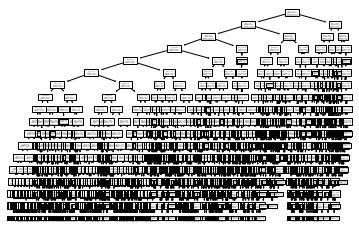

In [37]:
tree.plot_tree(decision_tree)

In [38]:
graph = Source(tree.export_graphviz(decision_tree,
                                    out_file=None,
                                    feature_names=[feature for feature in df.columns if feature != 'Arrest'],
                                    class_names=['Not Arrested', 'Arrested', 'Secret Third Thing']))
graph.format = 'png'
graph.render('decision_tree', view=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.235201 to fit


'decision_tree.png'

<h4>Neural Network</h4>

In [39]:
nn_iterations = 50
nn = MLPClassifier(activation='tanh',
                   hidden_layer_sizes=(X.shape[1] * 2),
                   max_iter=nn_iterations,
                   learning_rate_init=1e-4,
                   # verbose=True,
                   random_state=314)

nn.fit(X_train, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=264,
              learning_rate_init=0.0001, max_iter=50, random_state=314)

In [40]:
nn_predictions = nn.predict(X_test)
accuracy_score(nn_predictions, y_test)

0.8719175366723932

In [41]:
nn2 = MLPClassifier(activation='tanh',
                   hidden_layer_sizes=(X.shape[1] // 2),
                   max_iter=nn_iterations,
                   learning_rate_init=1e-4,
                   # verbose=True,
                   random_state=314)

nn2.fit(X_train, y_train)

nn3 = MLPClassifier(activation='tanh',
                   hidden_layer_sizes=(X.shape[1] // 4 * 3),
                   max_iter=nn_iterations,
                   learning_rate_init=1e-4,
                   # verbose=True,
                   random_state=314)

nn3.fit(X_train, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=99,
              learning_rate_init=0.0001, max_iter=50, random_state=314)

In [42]:
nn2_predictions = nn2.predict(X_test)
print(accuracy_score(nn2_predictions, y_test))

nn3_predictions = nn3.predict(X_test)
accuracy_score(nn3_predictions, y_test)

0.7914629311484076


0.7338971851460289


KeyboardInterrupt



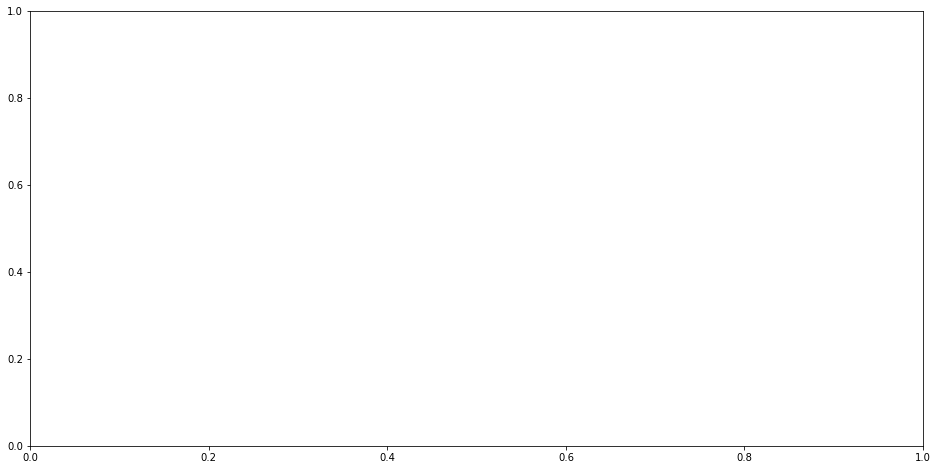

In [43]:
plt.subplots(figsize=(16, 8))
x_vals = [i for i in range(1, nn_iterations + 1)]

plt.plot(x_vals, nn.loss_curve_, color="cyan",  label="2x input layer")
plt.plot(x_vals, nn2.loss_curve_, color="pink",  label="1/2 input layer")
plt.plot(x_vals, nn3.loss_curve_, color="purple",  label="3/4 input layer")

plt.title("Neural Network Training Loss by Hidden Layer Size")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.margins(0, 0.3)
plt.legend()
plt.show()

In [ ]:
nn4 = MLPClassifier(activation='relu',
                   hidden_layer_sizes=(X.shape[1] * 2),
                   max_iter=nn_iterations,
                   learning_rate_init=1e-4,
                   # verbose=True,
                   random_state=314)

nn4.fit(X_train, y_train)

nn5 = MLPClassifier(activation='identity',
                   hidden_layer_sizes=(X.shape[1] * 2),
                   max_iter=nn_iterations,
                   learning_rate_init=1e-4,
                   # verbose=True,
                   random_state=314)

nn5.fit(X_train, y_train)

nn6 = MLPClassifier(activation='logistic',
                   hidden_layer_sizes=(X.shape[1] * 2),
                   max_iter=nn_iterations,
                   learning_rate_init=1e-4,
                   # verbose=True,
                   random_state=314)

nn6.fit(X_train, y_train)

In [ ]:
plt.subplots(figsize=(16, 8))

plt.plot(x_vals, nn.loss_curve_, color="blue",  label="tanh; f(x) = tanh(x)")
plt.plot([i for i in range(1, nn4.n_iter_ + 1)], nn4.loss_curve_, color="red",  label="relu; fx = max(0, x)")
plt.plot([i for i in range(1, nn5.n_iter_ + 1)], nn5.loss_curve_, color="orange",  label="identity; f(x) = x")
plt.plot([i for i in range(1, nn6.n_iter_ + 1)], nn6.loss_curve_, color="green",  label="logistic sigmoid; f(x) = 1 / (1 + e^(-x))")

plt.title("Neural Network Training Loss by Activation Function")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.margins(0, 0.3)
plt.legend()
plt.show()

<h3>Model Validation and Evaluation</h3>

<b>ALL (MOST) PLOTS AND SUCH SHOULD GO HERE</b>

In [ ]:
lr_score = round(test_accuracy, 5)
lr_matrix = confusion_matrix(lr_predictions, y_test)
plt.title(f'LR Confusion Matrix, Accuracy={lr_score}')
sns.heatmap(lr_matrix, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

plt.show()

lr_tpr = lr_matrix[1][1] / (lr_matrix[1][1] + lr_matrix[1][0])
lr_fpr = lr_matrix[0][1] / (lr_matrix[0][0] + lr_matrix[0][1])
lr_tnr = 1 - lr_fpr
lr_fnr = 1 - lr_tpr

print(f'True Positive Rate  : {lr_tpr}',
      f'False Positive Rate : {lr_fpr}',
      f'True Negative Rate  : {lr_tnr}',
      f'False Negative Rate : {lr_fnr}',
      sep='\n')

In [ ]:
dt_score = round(accuracy_score(tree_predictions, y_test), 5)
dt_matrix = confusion_matrix(tree_predictions, y_test)
plt.title(f'Decision Tree Confusion Matrix, Accuracy={dt_score}')
sns.heatmap(dt_matrix, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

plt.show()

dt_tpr = dt_matrix[1][1] / (dt_matrix[1][1] + dt_matrix[1][0])
dt_fpr = dt_matrix[0][1] / (dt_matrix[0][0] + dt_matrix[0][1])
dt_tnr = 1 - dt_fpr
dt_fnr = 1 - dt_tpr

print(f'True Positive Rate  : {dt_tpr}',
      f'False Positive Rate : {dt_fpr}',
      f'True Negative Rate  : {dt_tnr}',
      f'False Negative Rate : {dt_fnr}',
      sep='\n')

In [ ]:
nn_score = round(accuracy_score(nn_predictions, y_test), 5)
nn_matrix = confusion_matrix(nn_predictions, y_test)
plt.title(f'Neural Network Confusion Matrix, Accuracy={nn_score}')
sns.heatmap(nn_matrix, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

plt.show()

nn_tpr = nn_matrix[1][1] / (nn_matrix[1][1] + nn_matrix[1][0])
nn_fpr = nn_matrix[0][1] / (nn_matrix[0][0] + nn_matrix[0][1])
nn_tnr = 1 - nn_fpr
nn_fnr = 1 - nn_tpr

print(f'True Positive Rate  : {nn_tpr}',
      f'False Positive Rate : {nn_fpr}',
      f'True Negative Rate  : {nn_tnr}',
      f'False Negative Rate : {nn_fnr}',
      sep='\n')

In [ ]:
lr_train_sizes, lr_train_scores, lr_test_scores = learning_curve(LogisticRegression(multi_class='ovr',
                                                                                    max_iter=100,
                                                                                    C=0.8,
                                                                                    random_state=314),
                                                                X,
                                                                y,
                                                                scoring='accuracy',
                                                                train_sizes=np.linspace(0.01, 0.5, 20))

In [ ]:
dt_train_sizes, dt_train_scores, dt_test_scores = learning_curve(tree.DecisionTreeClassifier(criterion='entropy',
                                                                                        max_depth=3,
                                                                                        min_samples_leaf=8,
                                                                                        min_samples_split=6),
                                                                X,
                                                                y,
                                                                scoring='accuracy',
                                                                train_sizes=np.linspace(0.01, 0.5, 20))

In [ ]:
nn_train_sizes, nn_train_scores, nn_test_scores = learning_curve(MLPClassifier(activation='tanh',
                                                                               hidden_layer_sizes=(X.shape[1] * 2),
                                                                               max_iter=20,
                                                                               learning_rate_init=1e-4,
                                                                               random_state=314),
                                                                X,
                                                                y,
                                                                scoring='accuracy',
                                                                train_sizes=np.linspace(0.01, 0.5, 10))

For each model, plot the mean accuracy when using 5-fold cross-validation:

In [ ]:
lr_train_mean = np.mean(lr_train_scores, axis=1)
lr_train_std = np.std(lr_train_scores, axis=1)
lr_test_mean = np.mean(lr_test_scores, axis=1)
lr_test_std = np.std(lr_test_scores, axis=1)

In [ ]:
dt_train_mean = np.mean(dt_train_scores, axis=1)
dt_train_std = np.std(dt_train_scores, axis=1)
dt_test_mean = np.mean(dt_test_scores, axis=1)
dt_test_std = np.std(dt_test_scores, axis=1)

In [ ]:
nn_train_mean = np.mean(nn_train_scores, axis=1)
nn_train_std = np.std(nn_train_scores, axis=1)
nn_test_mean = np.mean(nn_test_scores, axis=1)
nn_test_std = np.std(nn_test_scores, axis=1)

In [ ]:
# Credit : https://www.projectpro.io/recipes/plot-learning-curve-in-python

plt.subplots(figsize=(12, 6))

plt.plot(lr_train_sizes, lr_train_mean, color="blue",  label="LR Training Scores")
plt.plot(lr_train_sizes, lr_test_mean, color="cyan", label="LR Cross-Validation Scores")

plt.plot(dt_train_sizes, dt_train_mean, color="red",  label="DT Training Scores")
plt.plot(dt_train_sizes, dt_test_mean, color="pink", label="DT Cross-Validation Scores")

plt.plot(nn_train_sizes, nn_train_mean, color="purple",  label="NN Training Scores")
plt.plot(nn_train_sizes, nn_test_mean, color="violet", label="NN Cross-Validation Scores")

# plt.fill_between(lr_train_sizes, lr_train_mean + lr_train_std, lr_train_mean - lr_train_std, color="lightgray")
# plt.fill_between(lr_train_sizes, lr_test_mean + lr_test_std, lr_test_mean - lr_test_std, color="lightgray")

# plt.fill_between(dt_train_sizes, dt_train_mean + dt_train_std, dt_train_mean - dt_train_std, color="gray")
# plt.fill_between(dt_train_sizes, dt_test_mean + dt_test_std, dt_test_mean - dt_test_std, color="gray")

# plt.fill_between(nn_train_sizes, nn_train_mean + nn_train_std, nn_train_mean - nn_train_std, color="darkgray")
# plt.fill_between(nn_train_sizes, nn_test_mean + nn_test_std, nn_test_mean - nn_test_std, color="darkgray")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.margins(0, 1.5)
plt.legend()
plt.show()

<h3>Results</h3>

In [ ]:
coefs = [(i, coef) for i, coef in enumerate(log_regression.coef_[0]) if abs(coef) > 0.75]
coefs.sort(key=lambda x:abs(x[1]), reverse=True)

for i, coef in coefs:
    print(f'{coef:.3f},\t', X.columns[i])